In [1]:
import os
import csv
import pandas as pd
import numpy as np

In [2]:
dataset_names=[]
X_trains=[]
y_trains=[]
X_tests=[]

path = "C:/Users/User/Desktop/SeniorYearFirstSem/DataScience/Competition1_code/Competition_data"
for folder_name in os.listdir(path):
    print(folder_name)
    dataset_names.append(folder_name)
    X_trains.append(pd.read_csv(f"{path}/{folder_name}/X_train.csv", header=0))
    y_trains.append(pd.read_csv(f"{path}/{folder_name}/y_train.csv", header=0))
    X_tests.append(pd.read_csv(f"{path}/{folder_name}/X_test.csv", header=0))

Dataset_1
Dataset_10
Dataset_11
Dataset_12
Dataset_13
Dataset_14
Dataset_15
Dataset_16
Dataset_17
Dataset_18
Dataset_19
Dataset_2
Dataset_20
Dataset_21
Dataset_22
Dataset_23
Dataset_24
Dataset_25
Dataset_26
Dataset_27
Dataset_28
Dataset_29
Dataset_3
Dataset_30
Dataset_31
Dataset_32
Dataset_33
Dataset_34
Dataset_35
Dataset_36
Dataset_37
Dataset_38
Dataset_39
Dataset_4
Dataset_40
Dataset_41
Dataset_42
Dataset_43
Dataset_44
Dataset_45
Dataset_46
Dataset_47
Dataset_48
Dataset_49
Dataset_5
Dataset_6
Dataset_7
Dataset_8
Dataset_9


In [3]:
## Train & Test & Split & Build Model
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

>> Preprocessing functions

In [4]:
import numpy as np
import pandas as pd

def remove_outlier(df, lower_quantile=0.25, upper_quantile=0.75, iqr_multiplier=1.5):
    """
    去除數值型特徵中的異常值（基於 IQR）。
    """
    numeric_cols = df.select_dtypes(include=['float64', 'int64'])
    for col in numeric_cols.columns:
        Q1 = df[col].quantile(lower_quantile)
        Q3 = df[col].quantile(upper_quantile)
        IQR = Q3 - Q1
        lower_bound = Q1 - iqr_multiplier * IQR
        upper_bound = Q3 + iqr_multiplier * IQR
        df[col] = np.clip(df[col], lower_bound, upper_bound)  # 將異常值剪裁到合理範圍
    return df

from sklearn.feature_selection import VarianceThreshold

def remove_low_variance(df, threshold=0.0001):
    """
    移除方差低於 threshold 的特徵。
    """
    selector = VarianceThreshold(threshold=threshold)
    numeric_data = df.select_dtypes(include=['float64', 'int64'])
    high_variance_data = selector.fit_transform(numeric_data)
    retained_features = numeric_data.columns[selector.get_support()]
    df = df[retained_features]
    return df

from scipy.stats import boxcox

def adjust_skewness(df, skew_threshold=2):
    """
    調整偏態，對偏度高於指定閾值的數值型特徵進行處理。
    """
    numeric_cols = df.select_dtypes(include=['float64', 'int64'])
    for col in numeric_cols.columns:
        skewness = df[col].skew()
        if skewness > skew_threshold:  # 偏態較高
            if (df[col] > 0).all():  # Box-Cox 要求數據為正數
                df[col], _ = boxcox(df[col] + 1e-6)
            else:  # 含有非正數，則使用 log1p
                df[col] = np.log1p(df[col] - df[col].min() + 1e-6)
    return df

def select_important_features(X, y, importance_threshold=0.005, retained_top_fraction=0.8):
    """
    基於特徵重要性選擇相關特徵，支持保留累計重要性占前 retained_top_fraction 的特徵。
    """
    # 確保 X 是 DataFrame 格式
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X)

    # 定義模型
    model = GradientBoostingClassifier(
        loss='log_loss',
        learning_rate=0.05,
        n_estimators=500,
        subsample=0.7,
        criterion='friedman_mse',
        min_samples_leaf=3,
        min_weight_fraction_leaf=0,
        max_depth=3,
        random_state=0,
        max_features=None,
        max_leaf_nodes=None
    )
    # 訓練模型
    model.fit(X, y)

    # 獲取特徵重要性並排序
    feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

    # 根據 importance_threshold 選擇初步篩選的特徵
    selected_features = feature_importances[feature_importances > importance_threshold].index.tolist()

    # 檢查篩選後的特徵數量
    if len(selected_features) < int(len(feature_importances) * retained_top_fraction):
        # 如果刪除的特徵過多，保留重要性最高的特徵
        num_to_retain = int(len(feature_importances) * retained_top_fraction)
        top_features = feature_importances.nlargest(num_to_retain).index.tolist()
        selected_features = list(set(selected_features + top_features))  # 合併去重
        print(f"Retained top {retained_top_fraction*100:.0f}% of features based on importance.")

    # 選擇重要特徵
    X_selected = X[selected_features]

    print(f"Selected {len(selected_features)} important features out of {X.shape[1]}. "
        f"(retained_top_fraction={retained_top_fraction}, importance_threshold={importance_threshold})")


    return X_selected, selected_features


from imblearn.over_sampling import SMOTE, ADASYN

def handle_class_imbalance(X, y, method='smote'):
    """
    使用 SMOTE 或 ADASYN 處理類別不平衡。
    """
    if method == 'smote':
        sampler = SMOTE(random_state=42)
    elif method == 'adasyn':
        sampler = ADASYN(random_state=42)
    else:
        raise ValueError(f"Unsupported imbalance method: {method}")
    
    X_resampled, y_resampled = sampler.fit_resample(X, y)
    print(f"Class imbalance handled: {dict(pd.Series(y_resampled).value_counts())}")
    return X_resampled, y_resampled


>> Pipeline

In [5]:
from sklearn.preprocessing import OneHotEncoder
def preprocess_pipeline(X, y=None, imbalance_method='smote', selected_features=None, encoder=None):
    """
    預處理流水線：分離數值和類別特徵，進行數據清理、特徵選擇以及類別不平衡處理。
    """
    print("Starting preprocessing pipeline...")

    # 分離數值型和類別型特徵
    numeric_features = X.select_dtypes(include=['float64', 'int64'])
    categorical_features = X.select_dtypes(include=['object', 'category'])

    # 測試階段
    if y is None:
        print("Testing stage: Applying pre-selected features and encoder...")

        # 驗證必要參數
        if selected_features is None:
            raise ValueError("Testing stage requires selected_features.")
        if categorical_features.shape[1] > 0 and encoder is None:
            raise ValueError("Testing stage requires encoder when categorical features are present.")

        # 處理類別型特徵（如果存在）
        if categorical_features.shape[1] > 0:
            if encoder is None:
                raise ValueError("Encoder is None during testing stage, but categorical features are present.")
            X_categorical = encoder.transform(categorical_features)
        else:
            X_categorical = np.empty((X.shape[0], 0))  # 空數組

        # 數值型特徵
        X_numeric = numeric_features.values  # 轉換為 NumPy

        # 合併數值型和類別型特徵
        X_combined = np.hstack([X_numeric, X_categorical])

        # 應用選擇的特徵
        if isinstance(selected_features[0], str):  # 如果選擇的特徵是列名
            all_feature_names = list(numeric_features.columns)
            if categorical_features.shape[1] > 0:
                all_feature_names += encoder.get_feature_names_out(categorical_features.columns).tolist()
            feature_indices = [all_feature_names.index(feat) for feat in selected_features]
            X_combined = X_combined[:, feature_indices]
        else:  # 如果選擇的特徵是索引
            X_combined = X_combined[:, selected_features]

        print(f"Testing stage: Final dataset shape after applying selected features: {X_combined.shape}")
        return X_combined, None, selected_features, encoder


    # 訓練階段執行完整預處理
    print("Training stage: Performing full preprocessing...")

    # Step 1: Process numeric features
    X_numeric = numeric_features.copy()
    X_numeric = remove_outlier(X_numeric)
    X_numeric = remove_low_variance(X_numeric)
    X_numeric = adjust_skewness(X_numeric)

    # Step 2: Process categorical features (One-hot encoding)
    if categorical_features.shape[1] > 0:
        encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
        X_categorical = encoder.fit_transform(categorical_features)
        categorical_feature_names = encoder.get_feature_names_out(categorical_features.columns)
    else:
        encoder = None
        X_categorical = np.empty((X_numeric.shape[0], 0))  # 空數組
        categorical_feature_names = []

    # Combine numeric and categorical features
    X_combined = np.hstack([X_numeric, X_categorical])
    all_feature_names = list(X_numeric.columns) + list(categorical_feature_names)

    # 修正特徵名稱長度
    if len(all_feature_names) > X_combined.shape[1]:
        all_feature_names = all_feature_names[:X_combined.shape[1]]

    X_combined = pd.DataFrame(X_combined, columns=all_feature_names)
    print(f"Combined dataset shape: {X_combined.shape}")

    # Step 3: Select important features
    X_combined, selected_features = select_important_features(X_combined, y)
    print(f"Selected features: {selected_features}")

    # Step 4: Handle class imbalance
    X_final, y_final = handle_class_imbalance(X_combined, y, method=imbalance_method)

    # 確保數據格式一致
    if isinstance(X_final, np.ndarray):
        X_final = pd.DataFrame(X_final, columns=selected_features)

    print(f"Final dataset shape: {X_final.shape}")
    print("Preprocessing pipeline completed.")
    return X_final, y_final, selected_features, encoder


In [3]:
import optuna

In [2]:
%reset -f

Gradient Boosting Classifier

>>> Final Model

In [70]:
average_auc = 0
y_predicts = []

# 資料集對應的最佳參數
dataset_best_params = [
    {'learning_rate': 0.010077337485660235, 'n_estimators': 593, 'subsample': 0.6211723814759181, 'max_depth': 4, 'min_samples_leaf': 1, 'max_features': None}, 
    {'learning_rate': 0.02142631575342677, 'n_estimators': 519, 'subsample': 0.7883256609731156, 'max_depth': 9, 'min_samples_leaf': 1, 'max_features': None}, 
    {'learning_rate': 0.04348841200617906, 'n_estimators': 520, 'subsample': 0.6465482025888715, 'max_depth': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt'}, 
    {'learning_rate': 0.01138098873554563, 'n_estimators': 431, 'subsample': 0.7470197815550073, 'max_depth': 8, 'min_samples_leaf': 2, 'max_features': None}, 
    {'learning_rate': 0.058105178960300145, 'n_estimators': 600, 'subsample': 0.6624082184492188, 'max_depth': 8, 'min_samples_leaf': 9, 'max_features': 'log2'}, 
    {'learning_rate': 0.03790156439639546, 'n_estimators': 492, 'subsample': 0.7528481892490324, 'max_depth': 2, 'min_samples_leaf': 8, 'max_features': 'sqrt'}, 
    {'learning_rate': 0.09330345811448283, 'n_estimators': 435, 'subsample': 0.6761660507326365, 'max_depth': 1, 'min_samples_leaf': 10, 'max_features': 'sqrt'},  
    {'learning_rate': 0.02354299305473999, 'n_estimators': 508, 'subsample': 0.6163325457675601, 'max_depth': 3, 'min_samples_leaf': 7, 'max_features': None}, 
    {'learning_rate': 0.010156512732095198, 'n_estimators': 456, 'subsample': 0.6377256504554993, 'max_depth': 6, 'min_samples_leaf': 9, 'max_features': 'sqrt'}, 
    {'learning_rate': 0.03167039640943675, 'n_estimators': 498, 'subsample': 0.7856305137888209, 'max_depth': 7, 'min_samples_leaf': 5, 'max_features': None}, 
    {'learning_rate': 0.02305105681376224, 'n_estimators': 542, 'subsample': 0.6286213882002543, 'max_depth': 1, 'min_samples_leaf': 9, 'max_features': 'sqrt'}, 
    {'learning_rate': 0.09544891873656708, 'n_estimators': 540, 'subsample': 0.7727695355340755, 'max_depth': 1, 'min_samples_leaf': 1, 'max_features': None}, 
    {'learning_rate': 0.030039276410472965, 'n_estimators': 446, 'subsample': 0.7131578529139428, 'max_depth': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}, 
    {'learning_rate': 0.02757079138263565, 'n_estimators': 562, 'subsample': 0.7754948648252753, 'max_depth': 4, 'min_samples_leaf': 6, 'max_features': None}, 
    {'learning_rate': 0.07612878282460031, 'n_estimators': 414, 'subsample': 0.7712449113198679, 'max_depth': 9, 'min_samples_leaf': 6, 'max_features': 'log2'}, 
    {'learning_rate': 0.015259151719213318, 'n_estimators': 486, 'subsample': 0.7242882959244935, 'max_depth': 6, 'min_samples_leaf': 7, 'max_features': 'sqrt'}, 
    {'learning_rate': 0.010938708925095053, 'n_estimators': 422, 'subsample': 0.6836801003646918, 'max_depth': 1, 'min_samples_leaf': 3, 'max_features': None}, 
    {'learning_rate': 0.09500930504687725, 'n_estimators': 479, 'subsample': 0.7244897177009232, 'max_depth': 3, 'min_samples_leaf': 9, 'max_features': 'sqrt'}, 
    {'learning_rate': 0.04272514785016383, 'n_estimators': 457, 'subsample': 0.657964444455378, 'max_depth': 8, 'min_samples_leaf': 3, 'max_features': 'log2'}, 
    {'learning_rate': 0.029624206655263555, 'n_estimators': 560, 'subsample': 0.6270013686148254, 'max_depth': 6, 'min_samples_leaf': 4, 'max_features': 'sqrt'}, 
    {'learning_rate': 0.08259946665808249, 'n_estimators': 566, 'subsample': 0.6668215981317285, 'max_depth': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}, 
    {'learning_rate': 0.03428450604611101, 'n_estimators': 445, 'subsample': 0.6001910904252774, 'max_depth': 3, 'min_samples_leaf': 1, 'max_features': 'log2'}, 
    {'learning_rate': 0.02830320533244099, 'n_estimators': 431, 'subsample': 0.6327092513235404, 'max_depth': 9, 'min_samples_leaf': 2, 'max_features': 'sqrt'}, 
    {'learning_rate': 0.01252784240724226, 'n_estimators': 433, 'subsample': 0.6792513078169191, 'max_depth': 2, 'min_samples_leaf': 2, 'max_features': 'log2'}, 
    {'learning_rate': 0.010872729440423822, 'n_estimators': 598, 'subsample': 0.6681371646189933, 'max_depth': 1, 'min_samples_leaf': 6, 'max_features': 'sqrt'}, 
    {'learning_rate': 0.01003232731486865, 'n_estimators': 498, 'subsample': 0.773296586551088, 'max_depth': 1, 'min_samples_leaf': 9, 'max_features': 'sqrt'}, 
    {'learning_rate': 0.014951887238343791, 'n_estimators': 511, 'subsample': 0.778601082073523, 'max_depth': 6, 'min_samples_leaf': 5, 'max_features': 'log2'}, 
    {'learning_rate': 0.011192987428276296, 'n_estimators': 408, 'subsample': 0.6631265939406491, 'max_depth': 3, 'min_samples_leaf': 6, 'max_features': 'sqrt'}, 
    {'learning_rate': 0.019429600537027882, 'n_estimators': 554, 'subsample': 0.6154545085521564, 'max_depth': 1, 'min_samples_leaf': 4, 'max_features': 'sqrt'}, 
    {'learning_rate': 0.012968472708523832, 'n_estimators': 570, 'subsample': 0.7272690201810293, 'max_depth': 5, 'min_samples_leaf': 4, 'max_features': None}, 
    {'learning_rate': 0.014970766900937202, 'n_estimators': 559, 'subsample': 0.7503258567803861, 'max_depth': 2, 'min_samples_leaf': 10, 'max_features': 'sqrt'}, 
    {'learning_rate': 0.015041994006973921, 'n_estimators': 527, 'subsample': 0.6779732798222989, 'max_depth': 1, 'min_samples_leaf': 1, 'max_features': 'log2'}, 
    {'learning_rate': 0.0677256335689162, 'n_estimators': 442, 'subsample': 0.6022564302090267, 'max_depth': 5, 'min_samples_leaf': 7, 'max_features': 'log2'}, 
    {'learning_rate': 0.016282811096796156, 'n_estimators': 430, 'subsample': 0.7079417407911488, 'max_depth': 1, 'min_samples_leaf': 9, 'max_features': 'log2'}, 
    {'learning_rate': 0.014050490024456146, 'n_estimators': 569, 'subsample': 0.7421939212991441, 'max_depth': 1, 'min_samples_leaf': 4, 'max_features': 'sqrt'}, 
    {'learning_rate': 0.08650036737627499, 'n_estimators': 427, 'subsample': 0.7495255799855911, 'max_depth': 5, 'min_samples_leaf': 10, 'max_features': None},  
    {'learning_rate': 0.03425903715860807, 'n_estimators': 400, 'subsample': 0.6231020184480272, 'max_depth': 2, 'min_samples_leaf': 8, 'max_features': 'sqrt'}, 
    {'learning_rate': 0.010057789959807844, 'n_estimators': 422, 'subsample': 0.6344871051027119, 'max_depth': 2, 'min_samples_leaf': 4, 'max_features': 'log2'}, 
    {'learning_rate': 0.09774864689785016, 'n_estimators': 527, 'subsample': 0.695887130208231, 'max_depth': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt'}, 
    {'learning_rate': 0.01379494806059802, 'n_estimators': 491, 'subsample': 0.7025995106825926, 'max_depth': 3, 'min_samples_leaf': 2, 'max_features': None}, 
    {'learning_rate': 0.01294411708651226, 'n_estimators': 421, 'subsample': 0.7488278138326251, 'max_depth': 3, 'min_samples_leaf': 2, 'max_features': 'log2'},  
    {'learning_rate': 0.045518726035471364, 'n_estimators': 589, 'subsample': 0.646112729220119, 'max_depth': 4, 'min_samples_leaf': 3, 'max_features': None}, 
    {'learning_rate': 0.05273089424822383, 'n_estimators': 471, 'subsample': 0.7269077096349348, 'max_depth': 1, 'min_samples_leaf': 10, 'max_features': 'sqrt'}, 
    {'learning_rate': 0.013464302881791537, 'n_estimators': 579, 'subsample': 0.6284899227419752, 'max_depth': 3, 'min_samples_leaf': 1, 'max_features': 'log2'}, 
    {'learning_rate': 0.0166914372414946, 'n_estimators': 448, 'subsample': 0.7317745291136347, 'max_depth': 5, 'min_samples_leaf': 10, 'max_features': 'log2'}, 
    {'learning_rate': 0.061973595164336516, 'n_estimators': 561, 'subsample': 0.7629570264269477, 'max_depth': 5, 'min_samples_leaf': 10, 'max_features': 'log2'}, 
    {'learning_rate': 0.07813821053225181, 'n_estimators': 444, 'subsample': 0.7609164249474171, 'max_depth': 10, 'min_samples_leaf': 6, 'max_features': 'sqrt'},
    {'learning_rate': 0.011035944673814423, 'n_estimators': 497, 'subsample': 0.6804844611790587, 'max_depth': 1, 'min_samples_leaf': 9, 'max_features': 'sqrt'}, 
    {'learning_rate': 0.025405145272101786, 'n_estimators': 544, 'subsample': 0.7349328113719463, 'max_depth': 6, 'min_samples_leaf': 4, 'max_features': 'sqrt'}
]

# 加入到主程式的最佳參數應用邏輯
for i in range(len(dataset_names)):
    print(f"Processing Dataset: {dataset_names[i]}")

    # 獲取當前資料集的特徵和標籤
    X_sample = X_trains[i]
    y_sample = y_trains[i].values.ravel()
    X_test = X_tests[i]

    # 確保資料格式一致
    if not isinstance(X_sample, pd.DataFrame):
        X_sample = pd.DataFrame(X_sample)
    if not isinstance(X_test, pd.DataFrame):
        X_test = pd.DataFrame(X_test)

    # 加入預先定義的最佳參數
    best_params = dataset_best_params[i]
    print(f"Using predefined best parameters for {dataset_names[i]}: {best_params}")

    # 創建模型
    model = GradientBoostingClassifier(**best_params, random_state=42)

    # 原始資料上的測試
    X_train, X_val, y_train, y_val = train_test_split(X_sample, y_sample, train_size=0.6, random_state=123)
    model.fit(X_train, y_train)
    y_val_proba_raw = model.predict_proba(X_val)[:, 1]
    auc_raw = roc_auc_score(y_val, y_val_proba_raw)

    print(f"Dataset {dataset_names[i]} Raw Validation AUC: {auc_raw:.4f}")

    # 如果 AUC 達到 1.0，直接跳過預處理
    if auc_raw >= 0.99:
        print(f"Dataset {dataset_names[i]} reached perfect AUC without preprocessing. Skipping preprocessing.")
        X_test_processed = X_test
    else:
        # 預處理資料
        X_sample_preprocessed, y_sample_preprocessed, selected_features, encoder = preprocess_pipeline(
            X_sample, y_sample, imbalance_method='smote'
        )

        # 預處理測試資料
        X_test_processed, _, _, _ = preprocess_pipeline(
            X_test, selected_features=selected_features, encoder=encoder
        )
        X_test_processed = pd.DataFrame(X_test_processed, columns=X_sample_preprocessed.columns)

        # 預處理後的測試
        X_train_preprocessed, X_val_preprocessed, y_train_preprocessed, y_val_preprocessed = train_test_split(
            X_sample_preprocessed, y_sample_preprocessed, train_size=0.6, random_state=123
        )
        model.fit(X_train_preprocessed, y_train_preprocessed)
        y_val_proba_preprocessed = model.predict_proba(X_val_preprocessed)[:, 1]
        auc_preprocessed = roc_auc_score(y_val_preprocessed, y_val_proba_preprocessed)

        print(f"Dataset {dataset_names[i]} Preprocessed Validation AUC: {auc_preprocessed:.4f}")

        # 判斷使用的資料集
        if auc_preprocessed > auc_raw:
            print(f"Using preprocessed data for Dataset {dataset_names[i]}.")
            X_sample, y_sample = X_sample_preprocessed, y_sample_preprocessed
        else:
            print(f"Using raw data for Dataset {dataset_names[i]}.")
            X_test_processed = X_test

    # 最終模型訓練和測試
    model.fit(X_sample, y_sample)

    # 修正測試資料列名
    X_test_processed = pd.DataFrame(X_test_processed, columns=X_sample.columns)

    y_test_proba = model.predict_proba(X_test_processed)[:, 1]
    y_predicts.append(pd.DataFrame(y_test_proba, columns=['y_predict_proba']))

    # 保存預測結果
    output_dir = os.path.join(path, dataset_names[i])
    os.makedirs(output_dir, exist_ok=True)
    y_predicts[-1].to_csv(os.path.join(output_dir, "y_predict.csv"), index=False)

    # 更新 AUC 統計
    auc_preprocessed = locals().get('auc_preprocessed', -1)
    average_auc += max(auc_raw, auc_preprocessed) if auc_preprocessed != -1 else auc_raw

# 平均 AUC 計算
average_auc /= len(dataset_names)
print(f"Average AUC = {average_auc:.4f}")

Processing Dataset: Dataset_1
Using predefined best parameters for Dataset_1: {'learning_rate': 0.010077337485660235, 'n_estimators': 593, 'subsample': 0.6211723814759181, 'max_depth': 4, 'min_samples_leaf': 1, 'max_features': None}
Dataset Dataset_1 Raw Validation AUC: 0.8704
Starting preprocessing pipeline...
Training stage: Performing full preprocessing...
Combined dataset shape: (444, 17)
Selected 17 important features out of 17. (retained_top_fraction=0.8, importance_threshold=0.005)
Selected features: ['Feature_1', 'Feature_2', 'Feature_5', 'Feature_9', 'Feature_6', 'Feature_4', 'Feature_10', 'Feature_20', 'Feature_3', 'Feature_13', 'Feature_12', 'Feature_11', 'Feature_7', 'Feature_16', 'Feature_8', 'Feature_17', 'Feature_19']
Class imbalance handled: {0: np.int64(313), 1: np.int64(313)}
Final dataset shape: (626, 17)
Preprocessing pipeline completed.
Starting preprocessing pipeline...
Testing stage: Applying pre-selected features and encoder...
Testing stage: Final dataset shape

>>> Plotting Graph

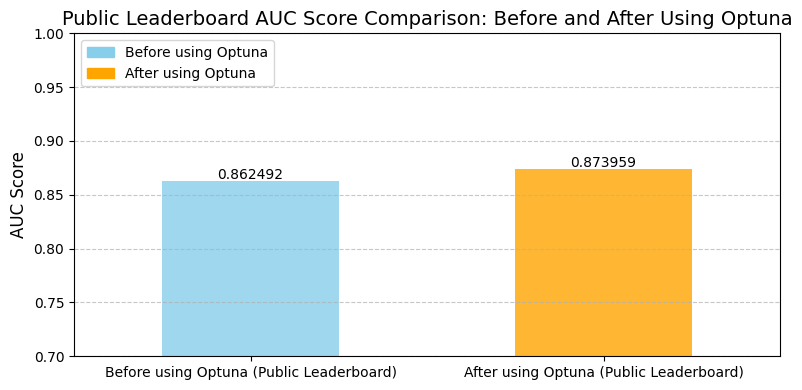

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# AUC values
auc_scores = [0.862492, 0.873959]

# Labels for the x-axis
labels = ["Before using Optuna (Public Leaderboard)", "After using Optuna (Public Leaderboard)"]

# Bar width and positions
x = np.arange(len(labels))
bar_width = 0.5

# Create the bar plot
plt.figure(figsize=(8, 4))
bars = plt.bar(x, auc_scores, color=['skyblue', 'orange'], width=bar_width, alpha=0.8)

# Add labels, title
plt.xticks(x, labels, ha='center', fontsize=10)
plt.ylabel('AUC Score', fontsize=12)
plt.title('Public Leaderboard AUC Score Comparison: Before and After Using Optuna', fontsize=14)

# Add custom legend
before_patch = mpatches.Patch(color='skyblue', label='Before using Optuna')
after_patch = mpatches.Patch(color='orange', label='After using Optuna')
plt.legend(handles=[before_patch, after_patch], loc='upper left', fontsize=10)

# Annotate each bar with its value
for bar, value in zip(bars, auc_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.002, f"{value:.6f}", 
             ha='center', fontsize=10)

# Add grid lines and set y-axis limit
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0.70, 1.00)  # Set y-axis range

# Manually adjust x-axis limits to reduce middle gap
plt.xlim(-0.5, 1.5)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


>>> Conditional Preprocessing value

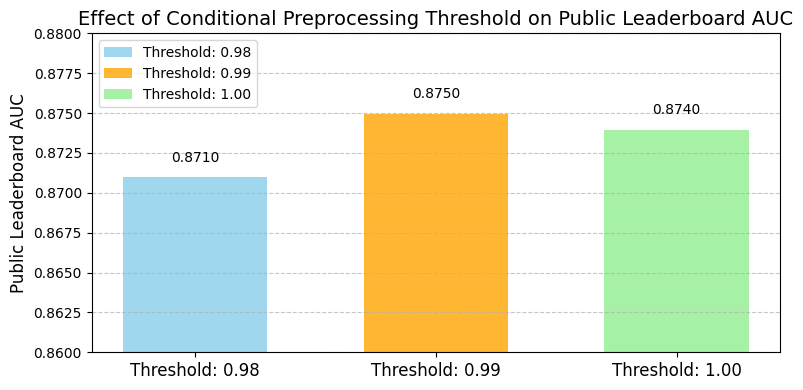

In [44]:
# Data
conditional_preprocessing_values = [0.98, 0.99, 1.00]
public_leaderboard_auc = [0.870963, 0.874964, 0.873959]
colors = ['skyblue', 'orange', 'lightgreen']  # Use three different colors

# Bar width and positions
x = np.arange(len(conditional_preprocessing_values))
bar_width = 0.6

# Create the bar plot
plt.figure(figsize=(8, 4))
bars = plt.bar(x, public_leaderboard_auc, color=colors, width=bar_width, alpha=0.8)

# Add labels, title, and legend
plt.xticks(x, [f"Threshold: {value:.2f}" for value in conditional_preprocessing_values], fontsize=12)
plt.ylabel('Public Leaderboard AUC', fontsize=12)
plt.title('Effect of Conditional Preprocessing Threshold on Public Leaderboard AUC', fontsize=14)
plt.legend(bars, [f"Threshold: {value:.2f}" for value in conditional_preprocessing_values], loc='upper left', fontsize=10)

# Annotate each bar with its value
for bar, value in zip(bars, public_leaderboard_auc):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.001, f"{value:.4f}", 
             ha='center', fontsize=10)

# Add grid lines and set y-axis limit
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0.86, 0.88)  # Adjust y-axis range for better visibility

# Adjust layout and display the plot
plt.tight_layout()
plt.show()



>>> Optuna number of trials

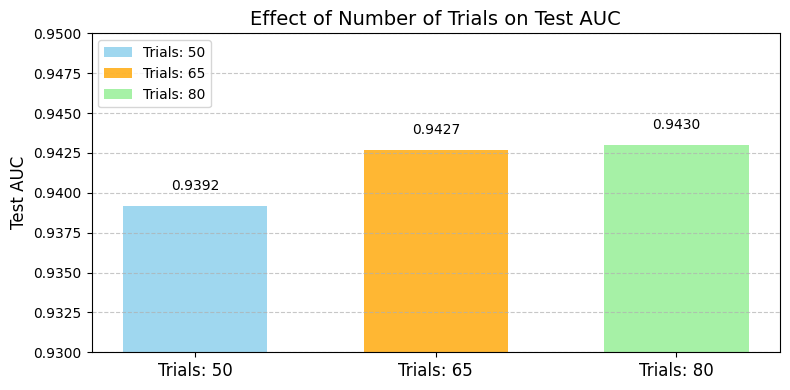

In [47]:
# Data
number_of_trials = [50, 65, 80]
test_auc = [0.9392, 0.9427, 0.9430]  

# Bar width and positions
x = np.arange(len(number_of_trials))
bar_width = 0.6

# Create the bar plot
plt.figure(figsize=(8, 4))
bars = plt.bar(x, test_auc, color=['skyblue', 'orange', 'lightgreen'], width=bar_width, alpha=0.8)

# Add labels, title, and legend
plt.xticks(x, [f"Trials: {trial}" for trial in number_of_trials], fontsize=12)
plt.ylabel('Test AUC', fontsize=12)
plt.title('Effect of Number of Trials on Test AUC', fontsize=14)
plt.legend(bars, [f"Trials: {trial}" for trial in number_of_trials], loc='upper left', fontsize=10)

# Annotate each bar with its value
for bar, value in zip(bars, test_auc):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.001, f"{value:.4f}", 
             ha='center', fontsize=10)

# Add grid lines and set y-axis limit
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0.93, 0.95)  # Adjust y-axis range for better visibility

# Adjust layout and display the plot
plt.tight_layout()
plt.show()



>>> Manual Parameter Adjustments for Preprocessing-Free Results

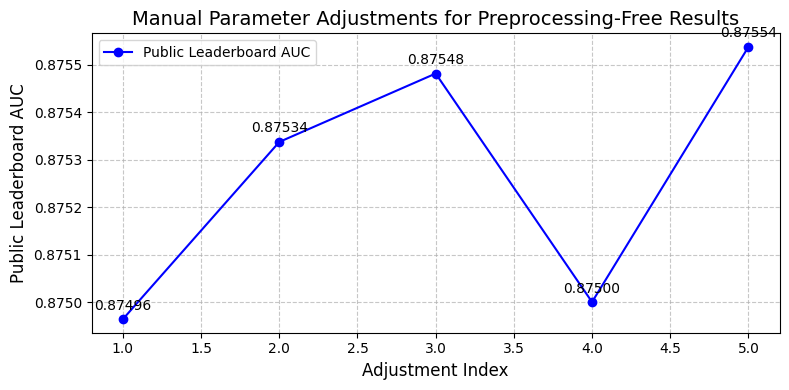

In [14]:
# Data
public_leaderboard_auc = [0.874964, 0.875337, 0.875481, 0.875, 0.875537]
adjustments = range(1, len(public_leaderboard_auc) + 1)  # Numbering the adjustments

# Create the line plot
plt.figure(figsize=(8, 4))
plt.plot(adjustments, public_leaderboard_auc, marker='o', linestyle='-', color='b', label='Public Leaderboard AUC')

# Add labels, title, and legend
plt.xlabel('Adjustment Index', fontsize=12)
plt.ylabel('Public Leaderboard AUC', fontsize=12)
plt.title('Manual Parameter Adjustments for Preprocessing-Free Results', fontsize=14)
plt.legend(fontsize=10)

# Annotate each point with its value
for x, y in zip(adjustments, public_leaderboard_auc):
    plt.text(x, y + 0.00002, f"{y:.5f}", ha='center', fontsize=10)

# Add grid
plt.grid(visible=True, linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()
